In [209]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [210]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

In [211]:
# Diane's Ages
pdfout = fits.getdata('LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [212]:
r13wd = fits.getdata('mc_rgbmembers.r13-l33-58932beta.fits.gz') 
_,d_r13_ind,d_r13wd_ind = np.intersect1d(r13['APOGEE_ID'],r13wd['APOGEE_ID'],return_indices=True)

r13_old = r13[d_r13_ind]
r13wd = r13wd[d_r13wd_ind]

r13dist = []
for i in range(len(r13wd)):
    r13dist.append(r13wd['DISO'][i][1])
    
c_icrs = SkyCoord(ra=r13_old['RA']*u.degree, dec=r13_old['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg13wd,ms_bg13wd = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

xLMC, yLMC, moddist = afunc.LMCdisk_cart(r13_old['RA'],r13_old['DEC'])

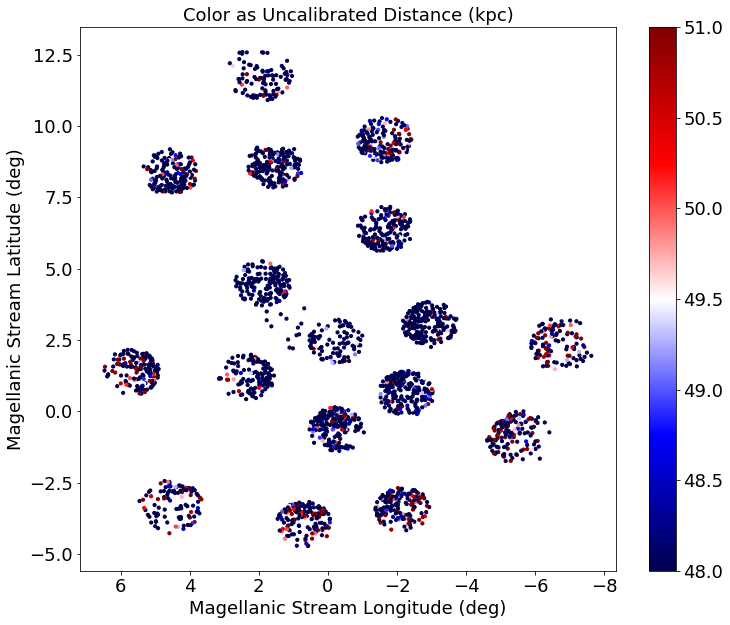

In [213]:
plt.figure(figsize=[12,10])

for i in range(len(ms_lg13wd)):
    if ms_lg13wd[i]-360<-180:
        ms_lg13wd[i] += 360.0
        
plt.scatter(ms_lg13wd-360,ms_bg13wd,c=np.asarray(r13dist)/1000.,cmap='seismic',vmax=51,vmin=48,s=10)
plt.gca().invert_xaxis()
plt.colorbar()
plt.title(r'Color as Uncalibrated Distance (kpc)',fontsize=18)
plt.ylabel(r'Magellanic Stream Latitude (deg)',fontsize=18)
plt.xlabel(r'Magellanic Stream Longitude (deg)',fontsize=18)
# plt.savefig('agemap.jpg',bbox_inches='tight')
plt.show()

In [214]:
def d2mu(distance):
    '''Convert distance to distance modulus'''
    return 5.*np.log10(distance) - 5.

def mu2d(mu):
    '''convert distance modulus to distance'''
    return 10**((1/5)*(mu+5))

In [215]:
# Calibrate Holtz Distances 

cal_holtz = mu2d(-0.99947 + 1.0878*d2mu(r13dist))/1000. #kpc

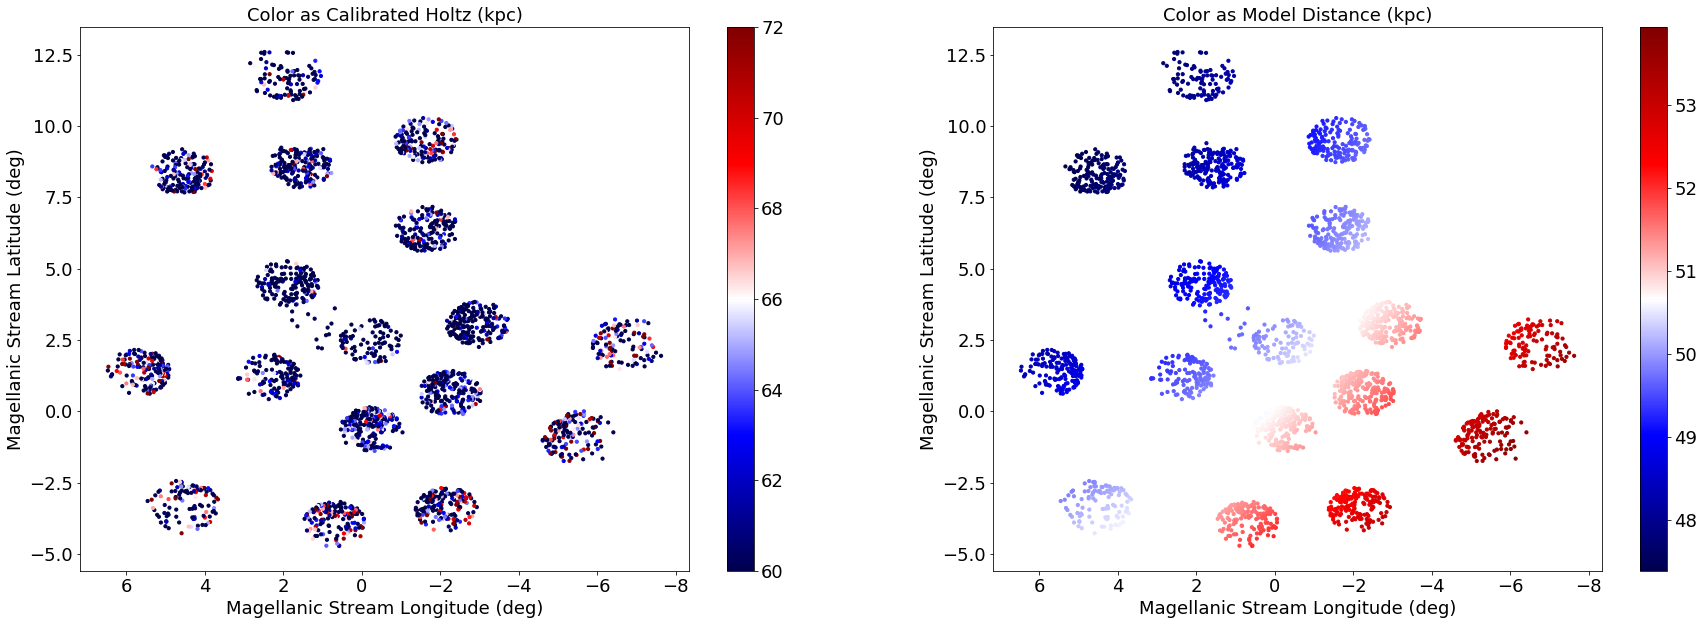

In [224]:
plt.figure(figsize=[30,10])
plt.subplot(1,2,1)
plt.scatter(ms_lg13wd-360,ms_bg13wd,c=cal_holtz,vmax=72,vmin=60,cmap='seismic',s=10)
plt.gca().invert_xaxis()
plt.colorbar()
plt.title(r'Color as Calibrated Holtz (kpc)',fontsize=18)
plt.ylabel(r'Magellanic Stream Latitude (deg)',fontsize=18)
plt.xlabel(r'Magellanic Stream Longitude (deg)',fontsize=18)

plt.subplot(1,2,2)
plt.scatter(ms_lg13wd-360,ms_bg13wd,c=moddist,cmap='seismic',s=10)
plt.gca().invert_xaxis()
plt.colorbar()
plt.title(r'Color as Model Distance (kpc)',fontsize=18)
plt.ylabel(r'Magellanic Stream Latitude (deg)',fontsize=18)
plt.xlabel(r'Magellanic Stream Longitude (deg)',fontsize=18)

plt.show()

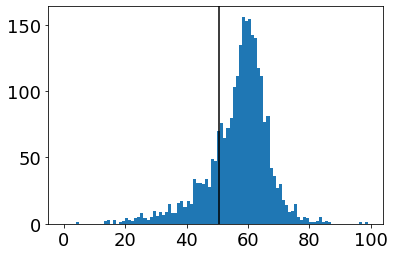

58.60563
5.0567493


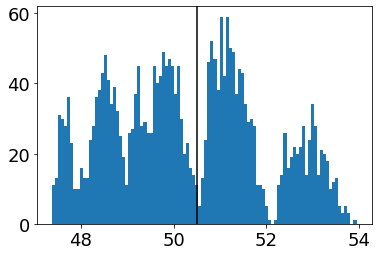

50.13203911093065
1.2241018215977526
step in MAD:  3.112665994147883


In [237]:
plt.hist(cal_holtz,range(0,100))
plt.axvline(50.5,c='k')
plt.show()

print(np.median(cal_holtz[np.where(np.isfinite(cal_holtz)==True)]))
print(afunc.mad(cal_holtz[np.where(np.isfinite(cal_holtz)==True)]))

plt.hist(moddist,bins=100)
plt.axvline(50.5,c='k')
plt.show()

print(np.median(moddist))
print(afunc.mad(moddist))
print('step in MAD: ', (np.max(moddist)-np.median(moddist))/afunc.mad(moddist))

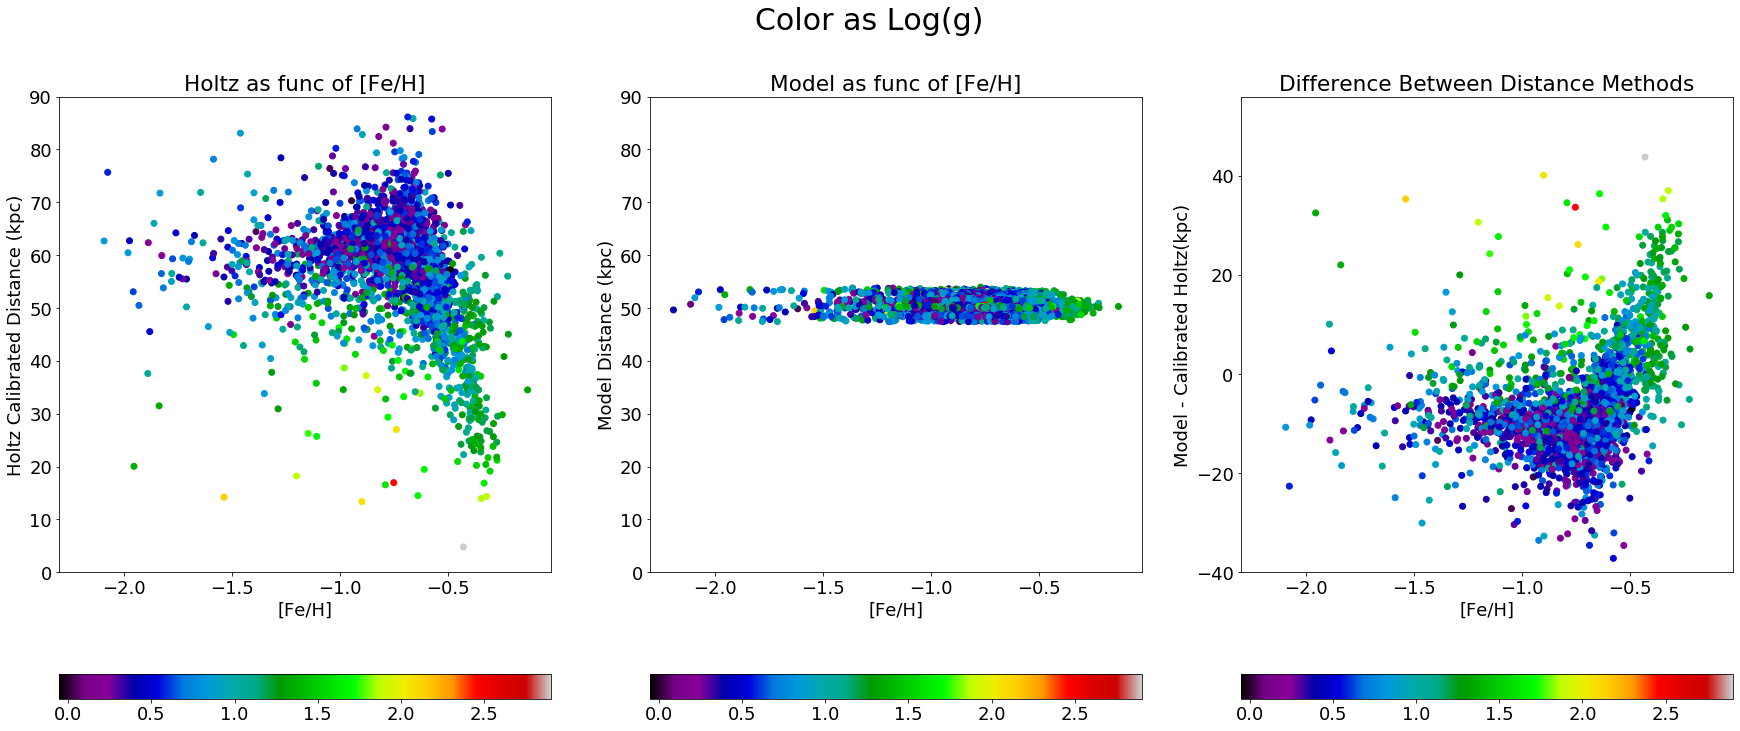

In [305]:
cp = 'nipy_spectral'

plt.figure(figsize=[30,12.5])
plt.suptitle(r'Color as Log(g)',fontsize=30)

plt.subplot(1,3,1)
plt.scatter(r13wd['FE_H'],cal_holtz,c=r13wd['LOGG'],cmap=cp)
plt.ylim(0,90)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Holtz Calibrated Distance (kpc)')
plt.title('Holtz as func of [Fe/H]')
plt.colorbar(orientation='horizontal')

plt.subplot(1,3,2)
plt.scatter(r13wd['FE_H'],moddist,c=r13wd['LOGG'],cmap=cp)
plt.ylim(0,90)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Model Distance (kpc)')
plt.title('Model as func of [Fe/H]')
plt.colorbar(orientation='horizontal')

plt.subplot(1,3,3)
plt.scatter(r13wd['FE_H'],moddist-cal_holtz,c=r13wd['LOGG'],cmap=cp)
plt.ylim(bottom=-40)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Model - Calibrated Holtz(kpc)')
plt.title('Difference Between Distance Methods')
plt.colorbar(orientation='horizontal')

plt.savefig('holtz_vs_model.png',bbox_inches='tight')
plt.show()



In [101]:
### blue loop cut
bloop = np.where((r13wd['TEFF']>=4100)&(r13wd['H']<=13.0)&((r13wd['J']-r13wd['K'])<=0.95))

bloop_cut = []
bloop_kee = []
for i in tqdm_notebook(range(len(r13wd)),desc='Done?'):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
    if i in np.squeeze(bloop).tolist():
        bloop_kee.append(i)
        
r13_wo_bl = r13wd[bloop_cut]
r13_bl = r13wd[bloop_kee]

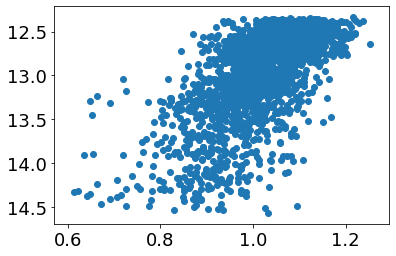

In [107]:
plt.scatter((r13wd['J']-r13wd['K'])[bloop_cut],r13wd['H'][bloop_cut])
plt.gca().invert_yaxis()

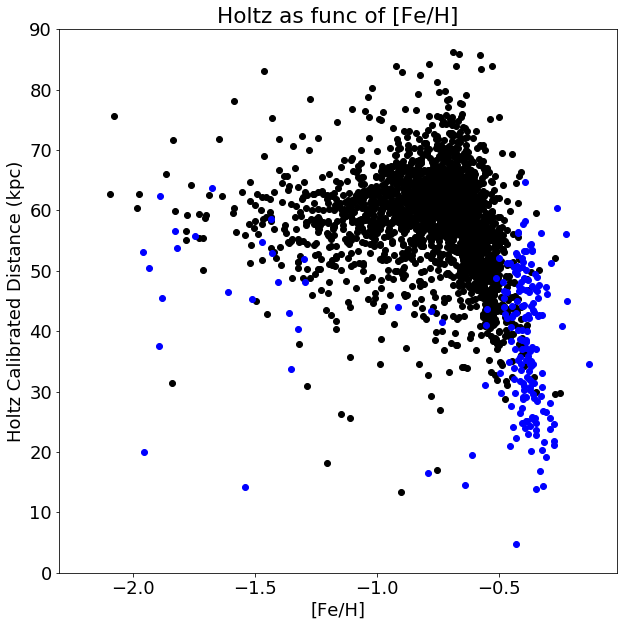

In [108]:
plt.figure(figsize=[10,10])
plt.scatter(r13_wo_bl['FE_H'],cal_holtz[bloop_cut],c='k')
# plt.colorbar(orientation='horizontal')
plt.scatter(r13_bl['FE_H'],cal_holtz[bloop_kee],c='b')
plt.ylim(0,90)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Holtz Calibrated Distance (kpc)')
plt.title('Holtz as func of [Fe/H]')
plt.savefig('blueloop_noblueloop.png',bbox_inches='tight')

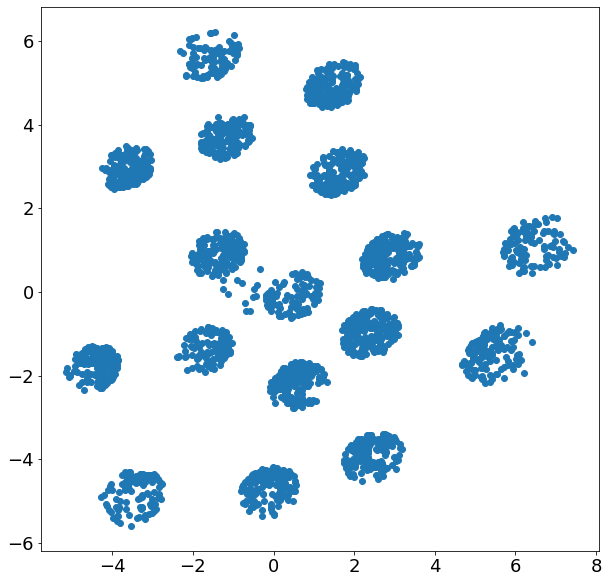

In [111]:
plt.figure(figsize=[10,10])

plt.scatter(xLMC,yLMC)

In [241]:
def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

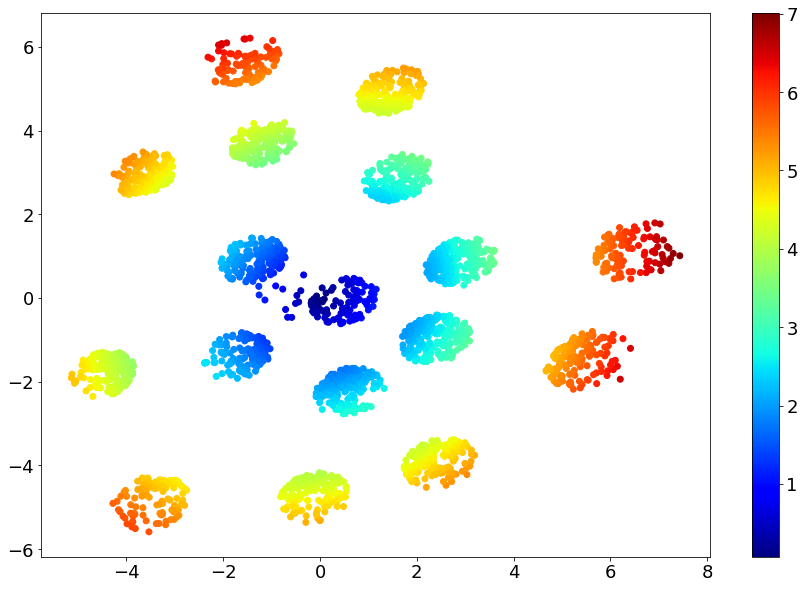

In [242]:
plt.figure(figsize=[15,10])
# plt.subplot(1,2,1)
# plt.scatter(xLMC,yLMC,c=elliptical_radius(10+90,xLMC,yLMC),cmap='jet')
# plt.colorbar()
# plt.subplot(1,2,2)
plt.scatter(xLMC,yLMC,c=elliptical_radius(xLMC,yLMC),cmap='jet')
plt.colorbar()
# plt.subplot(1,3,3)
# plt.scatter(xLMC,yLMC,c=elliptical_radius(xLMC,yLMC,0+90)-elliptical_radius(xLMC,yLMC,138+90))
# plt.colorbar()

In [259]:
ara,ara_head = fits.getdata('spDistances_ARA_58932beta.fits.gz',1,header=True)

In [265]:
allstar_r13_133_58932beta = fits.getdata('allStar-r13-l33-58932beta.fits.gz')

_,lmcr13,allr13 = np.intersect1d(r13['APOGEE_ID'],allstar_r13_133_58932beta['APOGEE_ID'],
                                         return_indices=True)

lmcr13_all = r13[lmcr13]
r13_58932beta = allstar_r13_133_58932beta[allr13]
lmc_ara = ara[allr13]

In [290]:
cal_ara = mu2d(-1.2628 + 1.0844*d2mu(lmc_ara['D1_med']*1000))/1000.

In [281]:
c_icrs = SkyCoord(ra=lmcr13_all['RA']*u.degree, dec=lmcr13_all['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

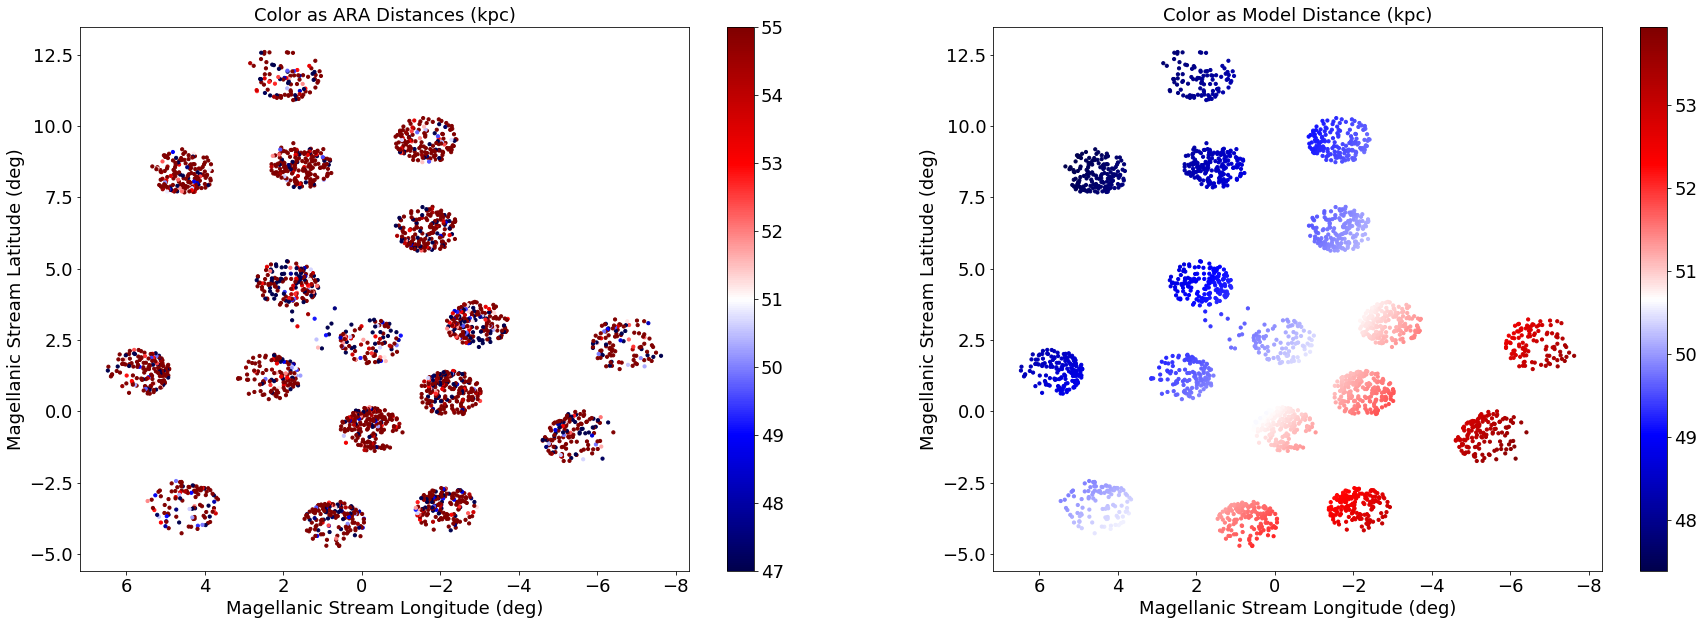

In [300]:
plt.figure(figsize=[30,10])
plt.subplot(1,2,1)
plt.scatter(ms_lg-360,ms_bg,c=cal_ara,vmax=55,vmin=47,cmap='seismic',s=10)
plt.gca().invert_xaxis()
plt.colorbar()
plt.title(r'Color as ARA Distances (kpc)',fontsize=18)
plt.ylabel(r'Magellanic Stream Latitude (deg)',fontsize=18)
plt.xlabel(r'Magellanic Stream Longitude (deg)',fontsize=18)

plt.subplot(1,2,2)
plt.scatter(ms_lg13wd-360,ms_bg13wd,c=moddist,cmap='seismic',s=10)
plt.gca().invert_xaxis()
plt.colorbar()
plt.title(r'Color as Model Distance (kpc)',fontsize=18)
plt.ylabel(r'Magellanic Stream Latitude (deg)',fontsize=18)
plt.xlabel(r'Magellanic Stream Longitude (deg)',fontsize=18)

plt.show()

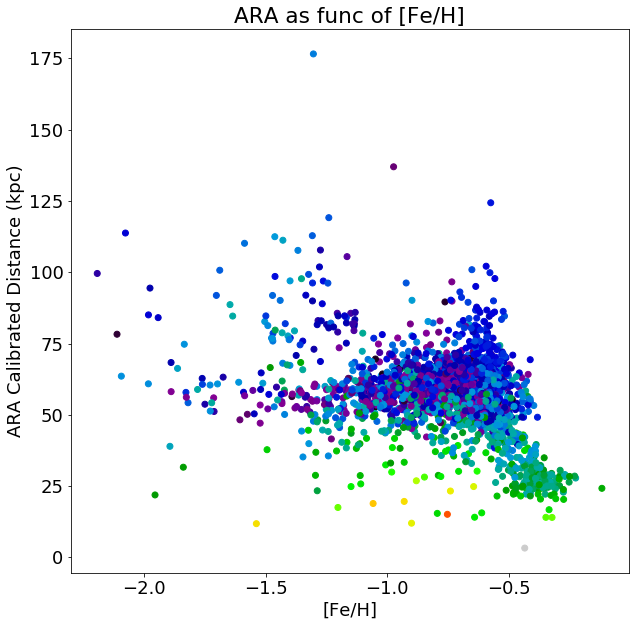

In [303]:
plt.figure(figsize=[10,10])
plt.scatter(lmcr13_all['FE_H'],cal_ara,c=lmcr13_all['LOGG'],cmap='nipy_spectral')
# plt.colorbar(orientation='horizontal')
# plt.ylim(0,90)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'ARA Calibrated Distance (kpc)')
plt.title('ARA as func of [Fe/H]')
# plt.savefig('blueloop_noblueloop.png',bbox_inches='tight')
plt.show()

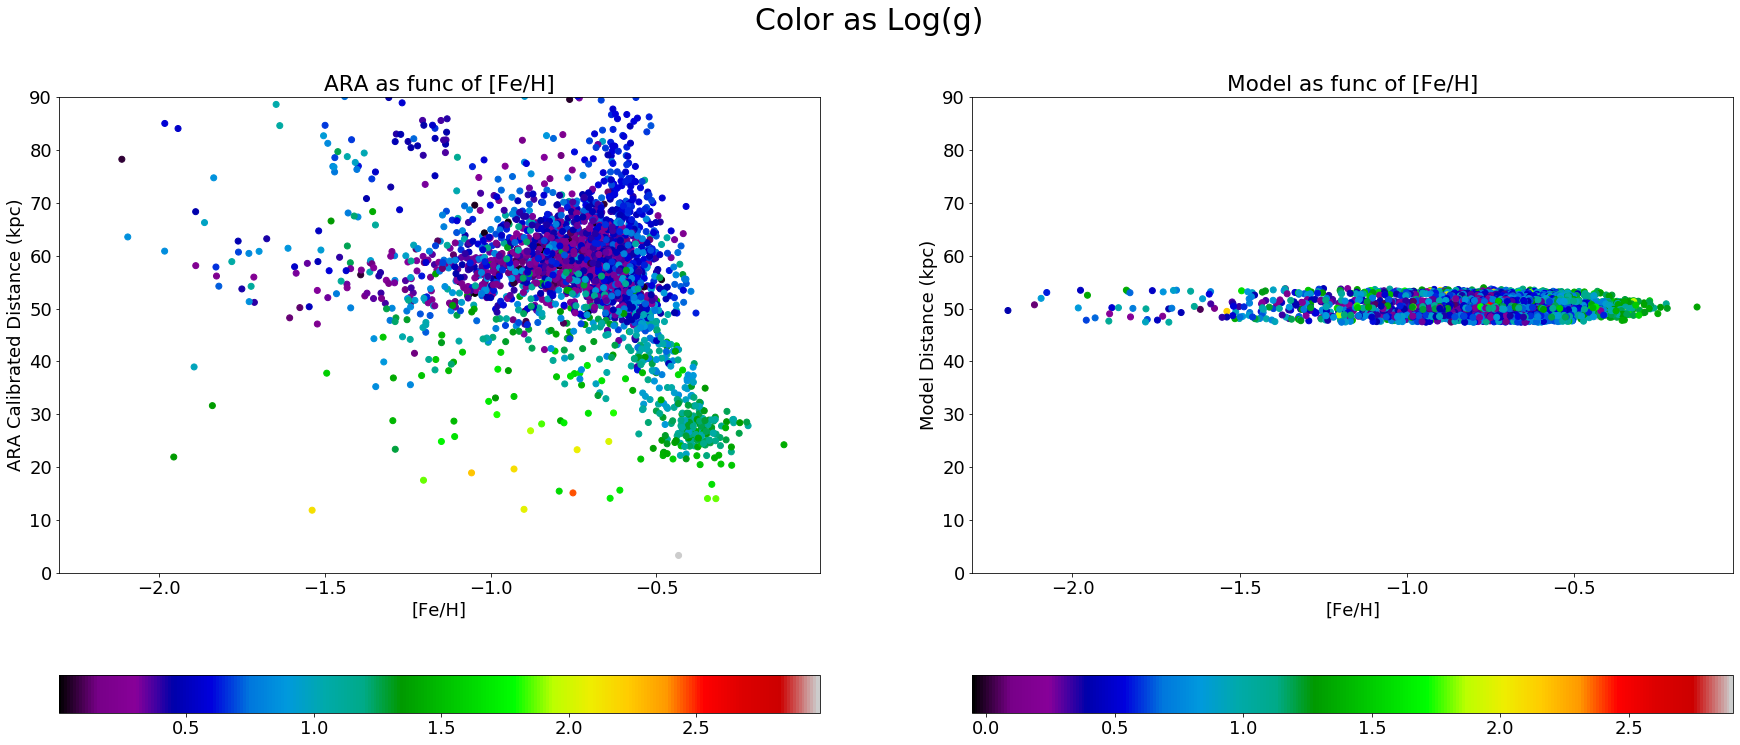

In [310]:
cp = 'nipy_spectral'

plt.figure(figsize=[30,12.5])
plt.suptitle(r'Color as Log(g)',fontsize=30)

plt.subplot(1,2,1)
plt.scatter(lmcr13_all['FE_H'],cal_ara,c=lmcr13_all['LOGG'],cmap=cp)
plt.ylim(0,90)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'ARA Calibrated Distance (kpc)')
plt.title('ARA as func of [Fe/H]')
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.scatter(r13wd['FE_H'],moddist,c=r13wd['LOGG'],cmap=cp)
plt.ylim(0,90)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Model Distance (kpc)')
plt.title('Model as func of [Fe/H]')
plt.colorbar(orientation='horizontal')

# plt.subplot(1,3,3)
# plt.scatter(r13wd['FE_H'],moddist-cal_ara,c=r13wd['LOGG'],cmap=cp)
# plt.ylim(bottom=-40)
# plt.xlabel(r'[Fe/H]')
# plt.ylabel(r'Model - Calibrated Holtz(kpc)')
# plt.title('Difference Between Distance Methods')
# plt.colorbar(orientation='horizontal')

# plt.savefig('holtz_vs_model.png',bbox_inches='tight')
plt.show()

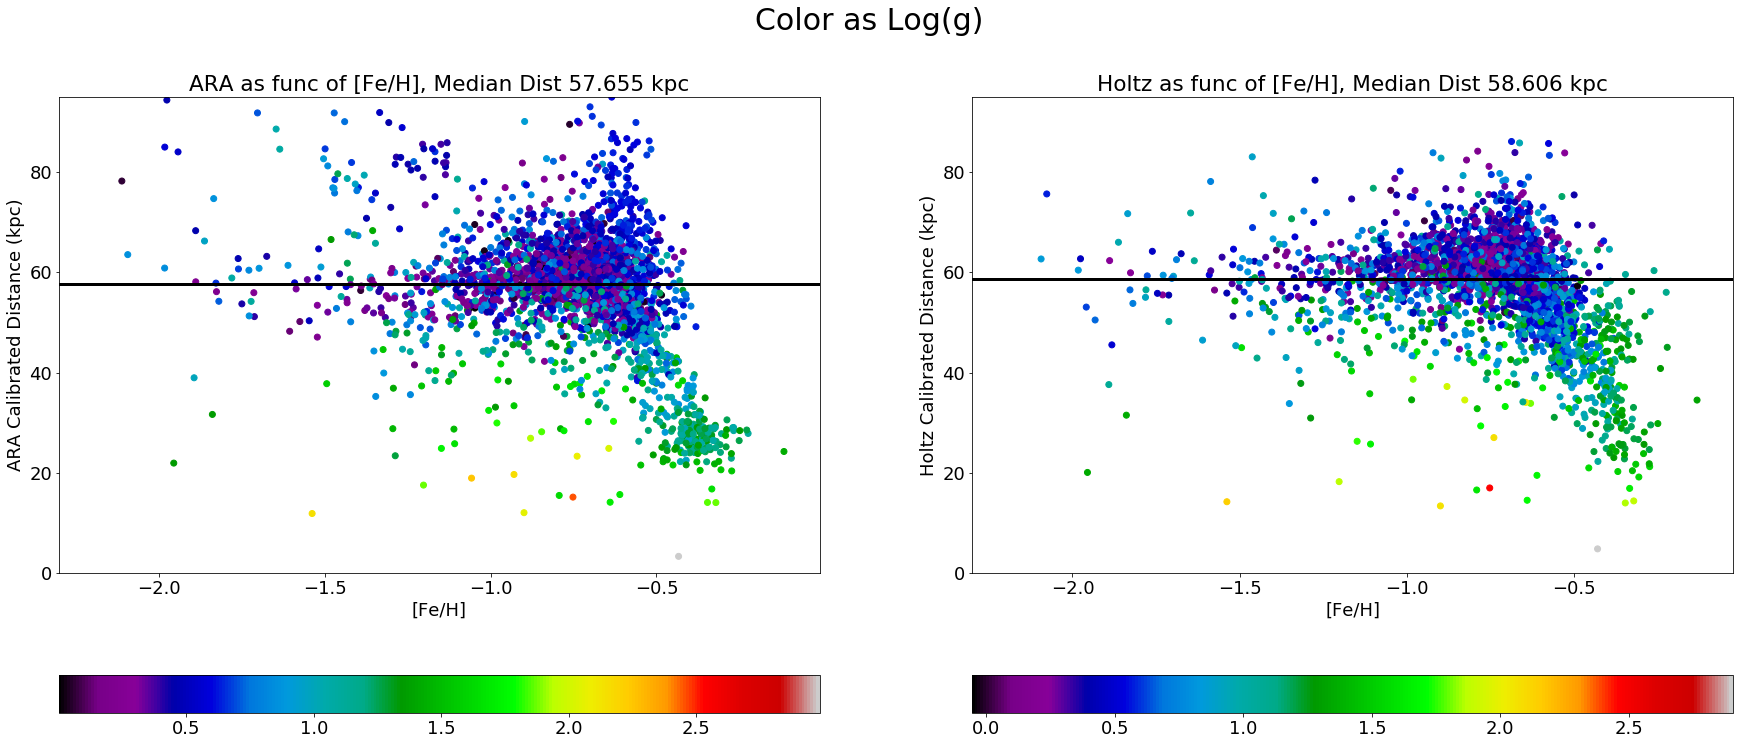

In [323]:
cp = 'nipy_spectral'

plt.figure(figsize=[30,12.5])
plt.suptitle(r'Color as Log(g)',fontsize=30)

plt.subplot(1,2,1)
plt.scatter(lmcr13_all['FE_H'],cal_ara,c=lmcr13_all['LOGG'],cmap=cp)
plt.axhline(np.nanmedian(cal_ara),c='k',lw='3.0')
plt.ylim(0,95)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'ARA Calibrated Distance (kpc)')
plt.title('ARA as func of [Fe/H], Median Dist {:.3f} kpc'.format(np.nanmedian(cal_ara)))
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.scatter(r13wd['FE_H'],cal_holtz,c=r13wd['LOGG'],cmap=cp)
plt.axhline(np.nanmedian(cal_holtz),c='k',lw='3.0')
plt.ylim(0,95)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Holtz Calibrated Distance (kpc)')
plt.title('Holtz as func of [Fe/H], Median Dist {:.3f} kpc'.format(np.nanmedian(cal_holtz)))
plt.colorbar(orientation='horizontal')

plt.savefig('ara_vs_holtz.pdf',bbox_inches='tight')

plt.show()

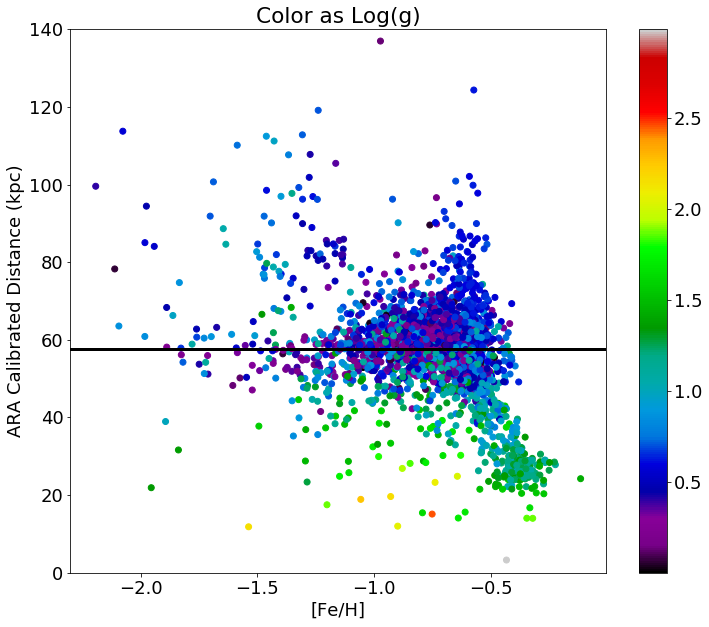

In [326]:
cp = 'nipy_spectral'

plt.figure(figsize=[12,10])
plt.scatter(lmcr13_all['FE_H'],cal_ara,c=lmcr13_all['LOGG'],cmap=cp)
plt.axhline(np.nanmedian(cal_ara),c='k',lw='3.0')
plt.ylim(0,140)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'ARA Calibrated Distance (kpc)')
plt.title('Color as Log(g)')
plt.colorbar()
plt.show()

In [336]:
set(r13['NVISITS'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}